In [ ]:
"""
PINN for the 3D Heat Equation using TensorFlow.

Solving the 3D heat equation using a
Physics-Informed Neural Network (PINN).

The equation is: ∂u/∂t - α(∂²u/∂x² + ∂²u/∂y² + ∂²u/∂z²) = 0
Domain: (x, y, z) in [0, 1]³, t in [0, 1]
Initial Condition (IC): u(x, y, z, 0) = sin(πx)sin(πy)sin(πz)
Boundary Conditions (BC): u=0 on all faces of the cube (Dirichlet)
Thermal Diffusivity (α): 0.1
"""

'\nPINN for the 3D Heat Equation using TensorFlow.\n\nThis script demonstrates how to solve the 3D heat equation using a\nPhysics-Informed Neural Network (PINN).\n\nThe equation is: ∂u/∂t - α(∂²u/∂x² + ∂²u/∂y² + ∂²u/∂z²) = 0\nDomain: (x, y, z) in [0, 1]³, t in [0, 1]\nInitial Condition (IC): u(x, y, z, 0) = sin(πx)sin(πy)sin(πz)\nBoundary Conditions (BC): u=0 on all faces of the cube (Dirichlet)\nThermal Diffusivity (α): 0.1\n'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# PROBLEM PARAMETERS 
ALPHA = 0.1
X_MIN, X_MAX = 0.0, 1.0
Y_MIN, Y_MAX = 0.0, 1.0
Z_MIN, Z_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0

# Number of collocation points
N_physics = 10000  # Points inside the domain
N_bc = 1500        # Points on each of the 6 boundary faces
N_ic = 3000        # Points for the initial condition

# Training parameters
EPOCHS = 15000
LEARNING_RATE = 1e-3

In [ ]:
#Model
def build_model(num_hidden_layers=4, num_neurons_per_layer=64):
    model = tf.keras.Sequential()
    # i/p layer (x, y, z, t)
    model.add(tf.keras.layers.InputLayer(input_shape=(4,)))
    # Hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation='tanh'))
    # o/p layer (u)
    model.add(tf.keras.layers.Dense(1, activation=None))
    return model

In [ ]:
#  GENERATING COLLOCATION (TRAINING) POINTS
# Physics points (inside the domain)
x_phys = tf.random.uniform((N_physics, 1), X_MIN, X_MAX)
y_phys = tf.random.uniform((N_physics, 1), Y_MIN, Y_MAX)
z_phys = tf.random.uniform((N_physics, 1), Z_MIN, Z_MAX)
t_phys = tf.random.uniform((N_physics, 1), T_MIN, T_MAX)

# Initial condition points (t=0)
x_ic = tf.random.uniform((N_ic, 1), X_MIN, X_MAX)
y_ic = tf.random.uniform((N_ic, 1), Y_MIN, Y_MAX)
z_ic = tf.random.uniform((N_ic, 1), Z_MIN, Z_MAX)
t_ic = tf.zeros((N_ic, 1))
# True IC values: u(x,y,z,0) = sin(πx)sin(πy)sin(πz)
u_ic_true = tf.sin(np.pi * x_ic) * tf.sin(np.pi * y_ic) * tf.sin(np.pi * z_ic)

# Boundary condition points (on the 6 faces of the cube)
# Face x=0 and x=1
x_bc_0 = tf.zeros((N_bc, 1))
x_bc_1 = tf.ones((N_bc, 1))
y_bc_x = tf.random.uniform((N_bc, 1), Y_MIN, Y_MAX)
z_bc_x = tf.random.uniform((N_bc, 1), Z_MIN, Z_MAX)
t_bc_x = tf.random.uniform((N_bc, 1), T_MIN, T_MAX)

# Face y=0 and y=1
y_bc_0 = tf.zeros((N_bc, 1))
y_bc_1 = tf.ones((N_bc, 1))
x_bc_y = tf.random.uniform((N_bc, 1), X_MIN, X_MAX)
z_bc_y = tf.random.uniform((N_bc, 1), Z_MIN, Z_MAX)
t_bc_y = tf.random.uniform((N_bc, 1), T_MIN, T_MAX)

# Face z=0 and z=1
z_bc_0 = tf.zeros((N_bc, 1))
z_bc_1 = tf.ones((N_bc, 1))
x_bc_z = tf.random.uniform((N_bc, 1), X_MIN, X_MAX)
y_bc_z = tf.random.uniform((N_bc, 1), Y_MIN, Y_MAX)
t_bc_z = tf.random.uniform((N_bc, 1), T_MIN, T_MAX)

# True BC values (u=0 on all boundaries)
u_bc_true = tf.zeros((N_bc, 1))

In [ ]:
# LOSS FUNCTION
def get_residual(model, x, y, z, t):
    """Computing the residual of the PDE using automatic differentiation."""
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, z, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, y, z, t])
            u = model(tf.concat([x, y, z, t], axis=1))

        # First derivatives
        du_dx = tape2.gradient(u, x)
        du_dy = tape2.gradient(u, y)
        du_dz = tape2.gradient(u, z)
        du_dt = tape2.gradient(u, t)

    # Second derivatives
    d2u_dx2 = tape.gradient(du_dx, x)
    d2u_dy2 = tape.gradient(du_dy, y)
    d2u_dz2 = tape.gradient(du_dz, z)

    del tape # Drop the tapes to free up memory
    del tape2

    residual = du_dt - ALPHA * (d2u_dx2 + d2u_dy2 + d2u_dz2)
    return residual


In [ ]:
# total loss
def compute_loss(model, x_phys, y_phys, z_phys, t_phys, x_ic, y_ic, z_ic, t_ic, u_ic_true):
    # Physics loss
    residual = get_residual(model, x_phys, y_phys, z_phys, t_phys)
    loss_phys = tf.reduce_mean(tf.square(residual))

    # Initial condition loss
    u_pred_ic = model(tf.concat([x_ic, y_ic, z_ic, t_ic], axis=1))
    loss_ic = tf.reduce_mean(tf.square(u_ic_true - u_pred_ic))

    # Boundary condition loss
    u_pred_bc_x0 = model(tf.concat([x_bc_0, y_bc_x, z_bc_x, t_bc_x], axis=1))
    u_pred_bc_x1 = model(tf.concat([x_bc_1, y_bc_x, z_bc_x, t_bc_x], axis=1))
    u_pred_bc_y0 = model(tf.concat([x_bc_y, y_bc_0, z_bc_y, t_bc_y], axis=1))
    u_pred_bc_y1 = model(tf.concat([x_bc_y, y_bc_1, z_bc_y, t_bc_y], axis=1))
    u_pred_bc_z0 = model(tf.concat([x_bc_z, y_bc_z, z_bc_0, t_bc_z], axis=1))
    u_pred_bc_z1 = model(tf.concat([x_bc_z, y_bc_z, z_bc_1, t_bc_z], axis=1))

    loss_bc = tf.reduce_mean(tf.square(u_pred_bc_x0 - u_bc_true)) + \
              tf.reduce_mean(tf.square(u_pred_bc_x1 - u_bc_true)) + \
              tf.reduce_mean(tf.square(u_pred_bc_y0 - u_bc_true)) + \
              tf.reduce_mean(tf.square(u_pred_bc_y1 - u_bc_true)) + \
              tf.reduce_mean(tf.square(u_pred_bc_z0 - u_bc_true)) + \
              tf.reduce_mean(tf.square(u_pred_bc_z1 - u_bc_true))

    total_loss = loss_phys + loss_ic + loss_bc
    return total_loss, loss_phys, loss_ic, loss_bc


In [ ]:
# TRAINING LOOP
pinn_model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

@tf.function
def train_step(x_p, y_p, z_p, t_p, x_i, y_i, z_i, t_i, u_i):
    """Single training step."""
    with tf.GradientTape() as tape:
        total_loss, _, _, _ = compute_loss(pinn_model, x_p, y_p, z_p, t_p, x_i, y_i, z_i, t_i, u_i)

    gradients = tape.gradient(total_loss, pinn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))
    return total_loss

print("Starting training...")
start_time = time.time()
for epoch in range(EPOCHS):
    train_step(x_phys, y_phys, z_phys, t_phys, x_ic, y_ic, z_ic, t_ic, u_ic_true)

    if (epoch + 1) % 1000 == 0:
        total_loss, loss_p, loss_i, loss_b = compute_loss(pinn_model, x_phys, y_phys, z_phys, t_phys, x_ic, y_ic, z_ic, t_ic, u_ic_true)
        print(f"Epoch [{epoch+1}/{EPOCHS}], "
              f"Loss: {total_loss.numpy():.4e}, "
              f"Physics: {loss_p.numpy():.4e}, "
              f"IC: {loss_i.numpy():.4e}, "
              f"BC: {loss_b.numpy():.4e}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Starting training...
Epoch [1000/15000], Loss: 1.4632e-02, Physics: 4.1701e-03, IC: 5.1480e-03, BC: 5.3139e-03
Epoch [2000/15000], Loss: 3.1260e-03, Physics: 1.5712e-03, IC: 5.7652e-04, BC: 9.7832e-04
Epoch [3000/15000], Loss: 1.2859e-03, Physics: 6.4085e-04, IC: 1.9099e-04, BC: 4.5410e-04
Epoch [4000/15000], Loss: 7.9182e-04, Physics: 3.6912e-04, IC: 1.0921e-04, BC: 3.1349e-04
Epoch [5000/15000], Loss: 5.9724e-04, Physics: 2.8205e-04, IC: 8.8657e-05, BC: 2.2654e-04
Epoch [6000/15000], Loss: 4.2147e-04, Physics: 1.9616e-04, IC: 5.1669e-05, BC: 1.7364e-04
Epoch [7000/15000], Loss: 3.5912e-04, Physics: 1.8655e-04, IC: 4.4153e-05, BC: 1.2842e-04
Epoch [8000/15000], Loss: 3.6598e-03, Physics: 1.6308e-04, IC: 7.2656e-04, BC: 2.7701e-03
Epoch [9000/15000], Loss: 2.2242e-04, Physics: 1.2300e-04, IC: 2.0529e-05, BC: 7.8889e-05
Epoch [10000/15000], Loss: 1.8950e-04, Physics: 1.0862e-04, IC: 1.6394e-05, BC: 6.4484e-05
Epoch [11000/15000], Loss: 1.6273e-04, Physics: 9.5575e-05, IC: 1.3500e-05, BC

Visualizing results...


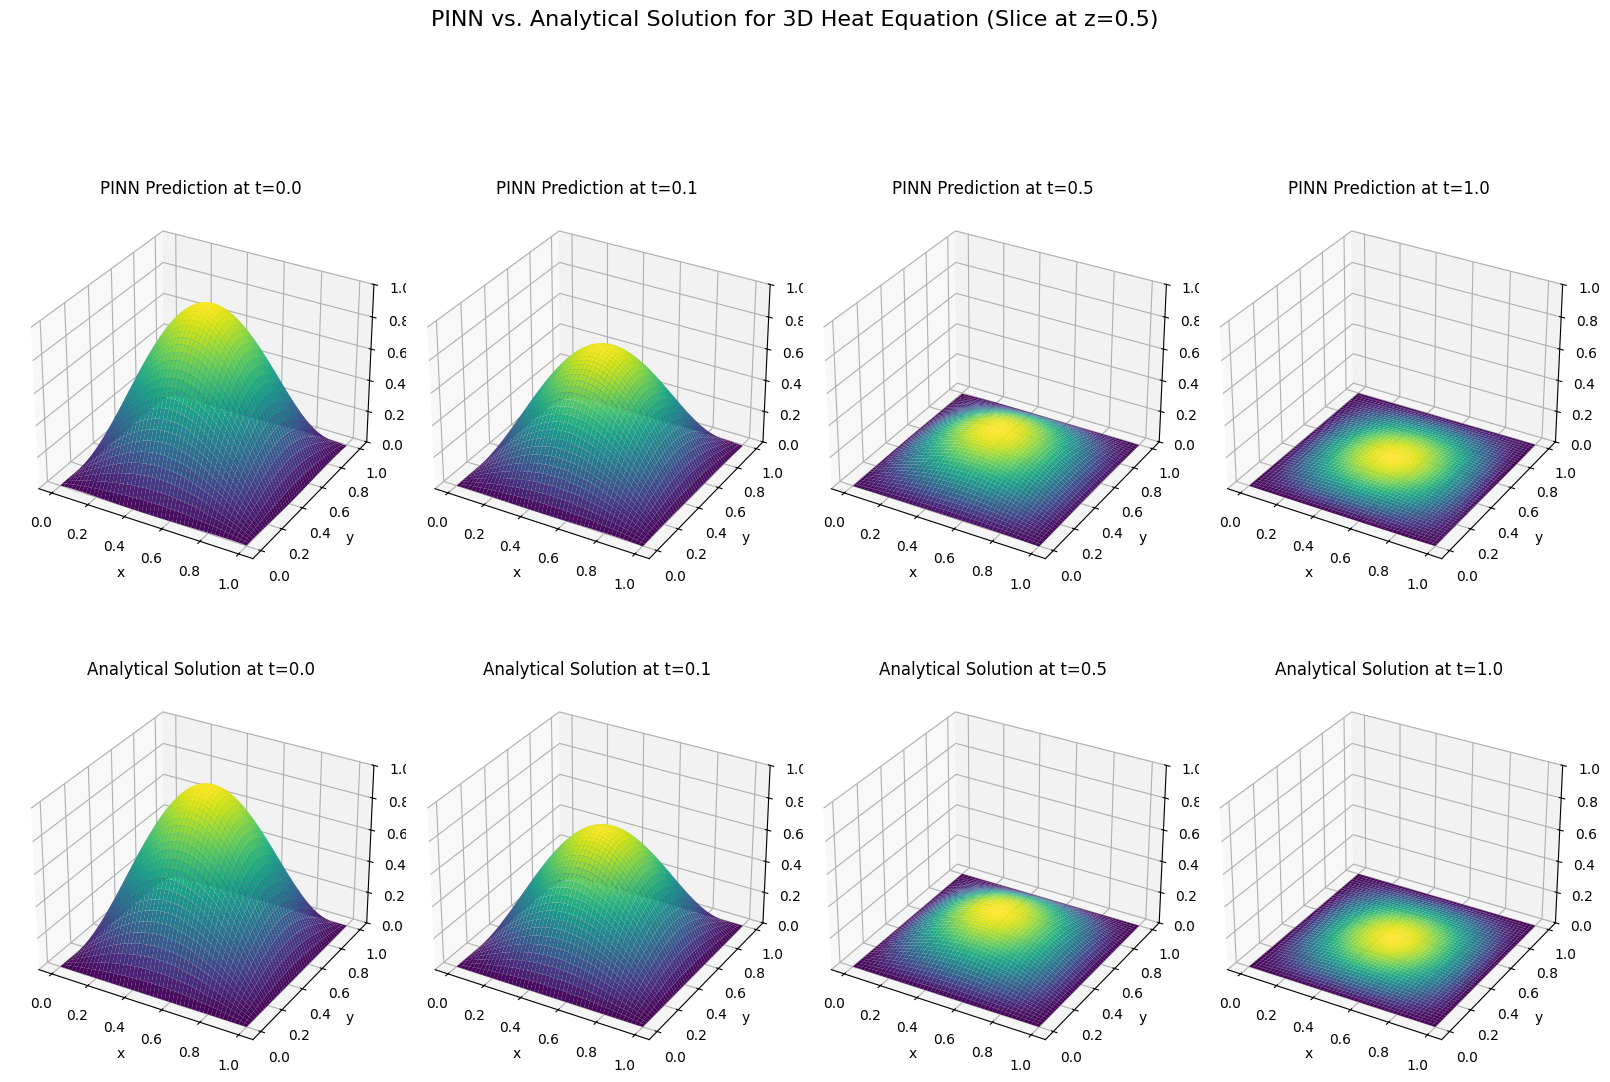

In [ ]:
print("Visualizing results...")

# Analytical solution for validation
def analytical_solution(x, y, z, t, alpha):
    return np.sin(np.pi * x) * np.sin(np.pi * y) * np.sin(np.pi * z) * \
           np.exp(-3 * alpha * np.pi**2 * t)

# Grid for plotting a 2D slice
N_plot = 50
x_plot = np.linspace(X_MIN, X_MAX, N_plot)
y_plot = np.linspace(Y_MIN, Y_MAX, N_plot)
X_grid, Y_grid = np.meshgrid(x_plot, y_plot)

# Plot slices at z=0.5 and at different times
plot_times = [0.0, 0.1, 0.5, 1.0]
Z_slice = 0.5 * np.ones_like(X_grid)

fig = plt.figure(figsize=(16, 12))
fig.suptitle(f'PINN vs. Analytical Solution for 3D Heat Equation (Slice at z={Z_slice[0,0]})', fontsize=16)

for i, t_val in enumerate(plot_times):
    T_slice = t_val * np.ones_like(X_grid)

    # Input for the model
    x_flat = tf.constant(X_grid.flatten(), dtype=tf.float32)[:, tf.newaxis]
    y_flat = tf.constant(Y_grid.flatten(), dtype=tf.float32)[:, tf.newaxis]
    z_flat = tf.constant(Z_slice.flatten(), dtype=tf.float32)[:, tf.newaxis]
    t_flat = tf.constant(T_slice.flatten(), dtype=tf.float32)[:, tf.newaxis]

    # PINN prediction
    u_pred_flat = pinn_model(tf.concat([x_flat, y_flat, z_flat, t_flat], axis=1))
    U_pred = tf.reshape(u_pred_flat, X_grid.shape).numpy()

    # Analytical solution
    U_analytical = analytical_solution(X_grid, Y_grid, Z_slice, T_slice, ALPHA)

    # Plotting PINN prediction
    ax = fig.add_subplot(2, 4, i + 1, projection='3d')
    ax.plot_surface(X_grid, Y_grid, U_pred, cmap='viridis')
    ax.set_title(f'PINN Prediction at t={t_val}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim(0, 1)

    # Plotting analytical solution
    ax = fig.add_subplot(2, 4, i + 5, projection='3d')
    ax.plot_surface(X_grid, Y_grid, U_analytical, cmap='viridis')
    ax.set_title(f'Analytical Solution at t={t_val}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()